Anastomus oscitans_Asian Openbill: 0.983
Ortalis motmot_Variable Chachalaca: 0.341


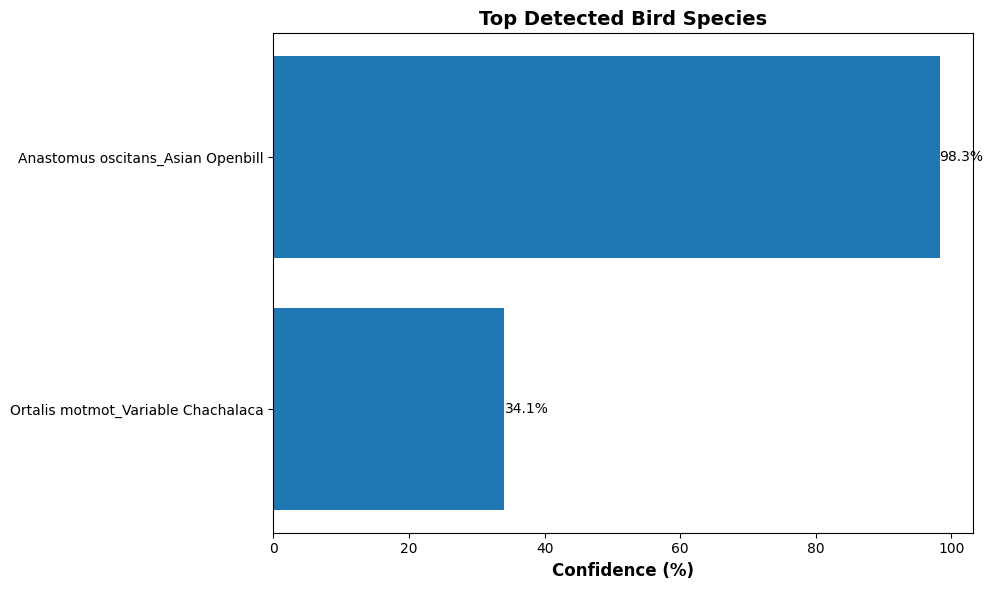

In [13]:
import numpy as np
import soundfile as sf
import librosa
import matplotlib.pyplot as plt
from tensorflow.lite.python.interpreter import Interpreter
import noisereduce as nr



def load_birdnet_model(model_path="models/birdnet/audio-model.tflite"):
    interpreter = Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    return interpreter

def load_labels(labels_path="models/birdnet/labels/en_us.txt"):
    with open(labels_path, "r", encoding="utf-8") as f:
        return [line.strip() for line in f if line.strip()]



def preprocess_audio(audio_path, target_sr=48000):
    """Load, convert to mono, resample to 48 kHz, and normalize"""
    # load audio
    y, sr = sf.read(audio_path, dtype="float32")

    # convert stereo to mono
    if y.ndim > 1:
        y = np.mean(y, axis=1)

    # resample if needed
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)

    # Normalize to -1..1 range
    if np.max(np.abs(y)) > 0:
        y = y / np.max(np.abs(y))

    return y.astype("float32")

# 
def predict_chunk(interpreter, chunk, labels, min_conf=0.1):
    """Run inference on one 3s chunk"""
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # padding or trim the audio chunk
    expected_len = input_details[0]["shape"][1]
    if len(chunk) < expected_len:
        chunk = np.pad(chunk, (0, expected_len - len(chunk)))
    else:
        chunk = chunk[:expected_len]

    # running the inference
    interpreter.set_tensor(input_details[0]["index"], chunk[None, :])
    interpreter.invoke()
    logits = interpreter.get_tensor(output_details[0]["index"])[0]
    probs = 1 / (1 + np.exp(-logits))
    
    results = [(labels[i], probs[i]) for i in range(len(probs)) if probs[i] >= min_conf]
    return sorted(results, key=lambda x: x[1], reverse=True)



def predict_species(interpreter, audio, labels, chunk_size=3*32000, min_conf=0.1):
    """Process entire clip in 3s chunks and average predictions"""
    scores = {}
    for i in range(0, len(audio), chunk_size):
        chunk = audio[i:i+chunk_size]
        preds = predict_chunk(interpreter, chunk, labels, min_conf=min_conf)
        for label, score in preds:
            scores[label] = scores.get(label, []) + [score]

    averaged = [(label, np.mean(vals)) for label, vals in scores.items()]
    return sorted(averaged, key=lambda x: x[1], reverse=True)[:10]



def plot_predictions(predictions, filename="birdnet_results.png"):
    species, scores = zip(*predictions)
    plt.figure(figsize=(10, 6))
    bars = plt.barh(species[::-1], [s * 100 for s in scores[::-1]], color="#1f77b4")
    plt.xlabel("Confidence (%)", fontsize=12, fontweight="bold")
    plt.title("Top Detected Bird Species", fontsize=14, fontweight="bold")
    for bar, score in zip(bars, scores[::-1]):
        plt.text(score * 100, bar.get_y() + bar.get_height()/2, f"{score*100:.1f}%",
                 va='center', ha='left', fontsize=10)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()


interpreter = load_birdnet_model()
labels = load_labels()
audio = preprocess_audio("asianopen.wav")

results = predict_species(interpreter, audio, labels, min_conf=0.2)
for label, score in results:
    print(f"{label}: {score:.3f}")
plot_predictions(results)

